In [53]:
!pip install -q transformers datasets torch torchvision albumentations roboflow pytorch_lightning

# init

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time

BASE_PATH = "../pdfBLines/datasetCrop"
CHECKPOINT_PATH = "../unet-blines/blines_dice0.93.pth.tar"


# Hyperparameters etc.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 8
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224  
PIN_MEMORY = True



/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Unet model

In [2]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512]
                 ) -> None:
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        self.transform = A.Compose(
            [
                A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )        

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)
    
    def predict(self,input_image_file):
        input_image = Image.open(input_image_file)
        augmentations = self.transform(image=np.array(input_image))
        image1 = augmentations['image']
        images = torch.unsqueeze(image1, 0)

        outputs = self(images)
        preds = torch.sigmoid(outputs)
        predicted_mask = (preds > 0.5).float()
        mask = self.prediction_to_vis(predicted_mask[0,:,:])
        mask = mask.resize(input_image.size)
        return mask


    def prediction_to_vis(sele,prediction):
        vis_shape = prediction.shape + (3,)
        vis = np.zeros(vis_shape)
        for i,c in color_map.items():
            vis[prediction == i] = color_map[i]
        return Image.fromarray(vis.astype(np.uint8).squeeze())

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape


test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


/Users/eliaweiss/opt/anaconda3/envs/LayoutLMv3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Utils

In [3]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


def check_accuracy(loader, model, device="cuda"):
    print("Checking accuracy")
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            acc = (preds == y).sum()
            numElem = torch.numel(preds)
            # print(idx, acc/numElem)
            
            num_correct += acc
            num_pixels += numElem
            dice_score += (2*(preds*y).sum())/(
                (preds+y).sum() + 1e-8
            )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )

        dice = dice_score/len(loader)
        print(f"Dice score: {dice}")

        model.train()
    return dice


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    print("Saving predictions")
    start = time.time()
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, os.path.join(folder,f"pred_{idx}.png")
        )
        torchvision.utils.save_image(y.unsqueeze(1), 
                                    os.path.join(folder,f"correct_{idx}.png")
                                     )
        break
        
    print(f"Saved predictions in {time.time()-start:.2f} seconds")
    model.train()


# Train

In [4]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In [5]:
# ckpt = torch.load("/Users/eliaweiss/work/unet-blines/blines_dice0.93.pth.tar")
ckpt = torch.load("/Users/eliaweiss/work/unet-blines/blines_dice0.93.pth.tar", map_location=torch.device(DEVICE))
load_checkpoint(ckpt, model)
# check_accuracy(val_loaders, model, device=DEVICE)     

=> Loading checkpoint


 # view results

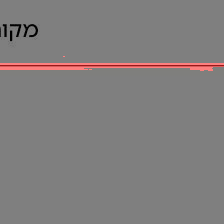

In [6]:
input_image_file = "../pdfBLines/datasetCrop/valid/1678281108-da80674ac533ff392cc03d66aac5cff0_9.jpg"
input_image = Image.open(input_image_file)

mask = model.predict(input_image_file)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img